# Week 6: NLP use-cases
This notebook accompanies the week 6 lecture.  This week focuses on a set of interesting use-cases in NLP using the techniques we've covered in class

In [4]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
import pickle

required = {'spacy', 'transformers'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import json
import numpy as np
import pandas as pd
import spacy
from spacy.matcher import Matcher, PhraseMatcher
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import transformers
# this will set the device on which to train
device = torch.device("cpu")
# if using collab, set your runtime to use GPU and use the line below
#device = torch.device("cuda:0")

I0720 09:28:04.804933 140735234007040 file_utils.py:39] PyTorch version 1.5.1 available.


## Unsupervised use-case: Movie genre "clusters"
Though we've dealt with several labelled datasets in our class, for the most part you will not have the advantage of labels on your dataset.  However, with the techniques we've covered, we can create informative groupings that may provide answers to some questions or facilitate labeling.

In [132]:
# read in movie descriptions from spoilers dataset
movies = pd.read_pickle('../data/spoilers_movies.pkl.gz')

# format a genre dataset, which will allow us to see how well our approach approximates the labelling
genres = np.unique(np.concatenate(movies.genre.values))
genre_dummies = np.zeros(shape=(len(movies), len(genres)))
for i, r in enumerate(movies.genre):
    for ii, g in enumerate(genres):
        if g in r:
            genre_dummies[i, ii] = 1
df_genre_dummies = pd.DataFrame(genre_dummies,
                               columns=genres,
                               index=movies.movie_id)

### Exercise: Choose a technique to process movie plot summaries
Think about some of the techniques we've already used (e.g. TFIDF, NMF, GloVe embeddings) and choose one for turning the raw summary text into a vector of information

In [50]:
# run word counts - TFIDF
tfidf = TfidfVectorizer(min_df=0.01, stop_words='english')
tfidf_vecs = tfidf.fit_transform(movies.plot_summary)

# examine sets of particularly "informative" words (i.e. high TF, low DF)
tfidf_df = pd.DataFrame(tfidf_vecs.toarray(),
            columns=tfidf.get_feature_names())
# what's the highest-weighted per movie, look at the top 10
tfidf_df.idxmax(axis=1).value_counts()[:10]

sam        2
gerry      2
angels     2
fbi        2
frank      2
beloved    2
peter      2
alien      2
king       2
gordon     2
dtype: int64

In [51]:
# alien seems pretty distinctive.  I imagine anything that has "alien" is probably sci-fi
movies[movies.plot_summary.str.find('alien')>-1]

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
1550,tt0103644,After escaping with Newt and Hicks from the mo...,1h 54min,"[Action, Horror, Sci-Fi]",6.4,1992-05-22,"In the movie's opening credits, the Sulaco, th..."
745,tt0120201,In the distant future high school kids are enc...,2h 9min,"[Action, Adventure, Sci-Fi]",7.2,1997-11-07,"In the distant future, several hundred years a..."
237,tt0115571,"Zane (Charlie Sheen), a young, mild-mannered a...",1h 55min,"[Sci-Fi, Thriller]",6.3,1996-05-31,"Zane Zaminski (Charlie Sheen), a radio astrono..."


In [107]:
# but a better measure here is comparing vectors
tfidf_sim = cosine_similarity(tfidf_df)
random_idx = np.random.randint(len(tfidf_sim))
# take the most similar for this random idx (aside from self)
movies.iloc[[random_idx,
            tfidf_sim[random_idx].argsort()[-2]]].plot_summary.values
# not clear if this is working, just pairwisw

array(["Tommy Callahan Jr. is a slow-witted, clumsy guy who recently graduated college after attending for seven years. His father, Big Tom Callahan, owns an auto parts factory in Ohio. When Tommy arrives back home, he finds he has a position at the factory waiting for him. His dad also introduces Tommy to the new brake pad division of the factory and to Tommy's soon-to-be stepmother, Beverly, and her son Paul. But when Big Tom dies, the factory threatens to go under unless the new brake pads are to be sold. Therefore, Tommy must go on the road to sell them, along with the assistance of Richard, Big Tom's right-hand man. Will Tommy save the company, or will the factory, and the town, go under?                Written by\nAnonymous",
       'New York based jazz pianist Willie Conway heads back to his small hometown of Knights Ridge, Massachusetts for a high school reunion. The trip is as much to go to the reunion and see his old friends - none of whom left Knights Ridge after graduation 

In [69]:
# run topic model - NMF
n_components = 10
nmf = NMF(n_components=n_components)
nmf_vecs = nmf.fit_transform(tfidf_vecs)

# examine topic model
def display_components(model, word_features, top_display=5):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print(" ".join(top_words))
display_components(nmf, tfidf.get_feature_names())


Topic 0:
family man decides home frank
Topic 1:
luke han princess leia skywalker
Topic 2:
life year love old sam
Topic 3:
ed mindspring esutton sutton man
Topic 4:
king porthos athos artagnan aramis
Topic 5:
movie follows film new building
Topic 6:
war general attack army force
Topic 7:
bond max jhailey cady hotmail
Topic 8:
school high friends girl hero
Topic 9:
gordon team hockey coach win


In [66]:
# i'd imagine  loading on 1 = star wars
movies.iloc[np.argsort(nmf_vecs[:, 1])[-5:]].plot_summary.values

array(["12-year-old Dre Parker has moved to China, and finds himself like a fish out of water. He befriends a fellow classmate, Mei Ying, only to make a rival, Cheng, who starts to bully and attack Dre. Soon, Mr Han, the maintenance man of Dre's apartment, fends off Cheng and his friends when they are attacking Dre and signs Dre up to fight in the Kung Fu tournament in return for the bullies laying off of Dre. Dre realizes Mr. Han is much more than a maintenance man, when he's revealed as a master of Kung Fu and Dre soon learns that Kung Fu is about self defense and peace, instead of violence and bloodshed.                Written by\nKennedy",
       'As the Clone Wars sweep through the galaxy, the heroic Jedi Knights struggle to maintain order and restore peace. More and more systems are falling prey to the forces of the dark side as the Galactic Republic slips further and further under the sway of the Separatists and their never-ending droid army. Anakin Skywalker and his Padawan lea

In [110]:
# with similarity
nmf_sim = cosine_similarity(nmf_vecs)
random_idx = np.random.randint(len(nmf_sim))
# take the most similar for this random idx (aside from self)
movies.iloc[[random_idx,
            nmf_sim[random_idx].argsort()[-2]]].plot_summary.values
# not clear if this is working, just pairwise

array(["Luke Skywalker, Han Solo, Princess Leia and Chewbacca face attack by the Imperial forces and its AT-AT walkers on the ice planet Hoth. While Han and Leia escape in the Millennium Falcon, Luke travels to Dagobah in search of Yoda. Only with the Jedi master's help will Luke survive when the dark side of the Force beckons him into the ultimate duel with Darth Vader.                Written by\nJwelch5742",
       'The Imperial Forces, under orders from cruel Darth Vader, hold Princess Leia hostage in their efforts to quell the rebellion against the Galactic Empire. Luke Skywalker and Han Solo, captain of the Millennium Falcon, work together with the companionable droid duo R2-D2 and C-3PO to rescue the beautiful princess, help the Rebel Alliance and restore freedom and justice to the Galaxy.                Written by\nJwelch5742'],
      dtype=object)

So far we've been looking at different slices of these models/heuristics.  But the purpose, as we've covered before, is to go from unstructured text and a lot of noise, to distilled representations.  In SVM models, we used the representations as input and trained weights on each dimension.  In clustering, we'll be embedding our text in "representation space" and grouping those representations.

The method we're using here is called K-Means clustering.  Refer to the slides for an explanation.  Suffice to say here, it's a fairly simple method for creating those groups.

In [141]:
# clustering K-means
clusterer = KMeans(n_clusters=5)
clusterer.fit(nmf_vecs)
cluster_preds = clusterer.predict(nmf_vecs)

# how well did our clustering do
print('Inertia (Sum of squared distances to cluster center):', clusterer.inertia_)

Inertia (Sum of squared distances to cluster center): 7.561936280646607


In [181]:
# how are these clusters split by genre
# just subseting to our top 5 genres, for ease of viewing
top_genres = df_genre_dummies.sum().nlargest(n=5).index.tolist()
cluster_by_genre = df_genre_dummies[top_genres].groupby(cluster_preds).sum()
cluster_by_genre
# seems like we're seeing a lot in one cluster, yikes!

,Drama,Comedy,Adventure,Action,Crime
0,7.0,3.0,4.0,4.0,2.0
1,77.0,52.0,39.0,35.0,34.0
2,2.0,1.0,2.0,2.0,2.0
3,0.0,0.0,3.0,3.0,0.0
4,0.0,1.0,3.0,3.0,0.0


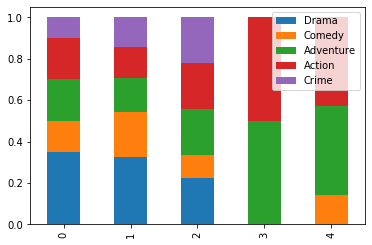

In [194]:
# get the % of each cluster in each genre
cluster_by_genre.apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True)

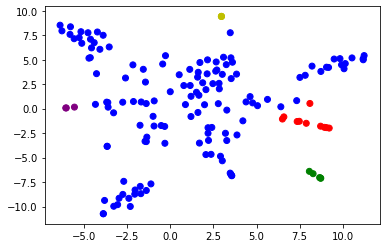

In [165]:
# one way to visualize this: a two-dimensional decomposition (T-SNE)
# see https://scikit-learn.org/stable/modules/manifold.html#t-sne for more info
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# fitting to 2 components
tsne_decomposition = TSNE(n_components=2, random_state=42).fit_transform(nmf_vecs)
fig, ax = plt.subplots()
# colors based on clusters
color_cycle = ['r', 'b', 'g', 'y', 'purple']
ax.scatter(tsne_decomposition[:,0], tsne_decomposition[:,1],
          c=[color_cycle[c] for c in cluster_preds])

### Exercise: Experiment with clustering
We've tried out a specific use of KMeans with a specific set of features, but there are tons of other ways to approach this.  Spend some time experimenting with different KMeans parameters and using other sets of features.  

Some example experiments:
- Tuning the number of clusters based on lowest inertia
- Fitting clusters to vectors of spatial information (e.g. cosine similarity)
- Trying other featuresets (e.g. TFIDF)

See if you can find a solution where the clusters seem to map on to genres to some extent, or at least where we don't see these big clusters.

## Named-Entity Recognition
The use-case we'll be covering in the slides might be considered "semi-supervised".  In a lot of cases, you may have an inventory of named-entities, but not necessary a fully labelled set of text.  In this use-case, we'll use our movie  dataset and a simple pattern matching implemented in SpaCy to train a NER model from scratch to recognize locations and actors.

In [5]:
# how to use spaCy's PhraseMatcher
# adapted from https://spacy.io/usage/rule-based-matching#phrasematcher
# load a language model
from spacy.lang.en import English
en = English()
matcher = PhraseMatcher(en.vocab)
inventories = {'people': ["Barack Obama", "Angela Merkel"],
           'locations': ["Washington, D.C.", "Oval Office"]}
for k in inventories:           
    matcher.add(k, # label for the match 
                None, # no custom function for dealing with matches ("callback")
                *[en(text) for text in inventories[k]])

doc = en("German Chancellor Angela Merkel and US President Barack Obama "
          "converse in the Oval Office inside the White House in Washington, D.C.")
matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]
    # note: match_id is stored as an index within the vocab
    print(match_id, en.vocab[match_id].text, span.text)

7593739049417968140 people Angela Merkel
7593739049417968140 people Barack Obama
13063876858105367867 locations Oval Office
13063876858105367867 locations Washington, D.C.


### Exercise: Use PhraseMatcher to identify entities from the inventory in the spoilers dataset

In [2]:
# read in reviews descriptions from spoilers dataset
reviews = pd.read_pickle('../data/spoilers_reviews.pkl.gz')
# an inventory of 288 academy award nominated actors 
actor_inventory = pickle.load(open('../data/actors_inventory.pkl', 'rb'))
# a set of US cities
city_inventory = pickle.load(open('../data/city_inventory.pkl', 'rb'))
# just splitting off state (think why this might be appropriate!)
city_inventory = [x.split(',')[0] for x in city_inventory]

In [36]:
# adapted from https://spacy.io/usage/rule-based-matching#phrasematcher
from spacy.lang.en import English
en = English()
matcher = PhraseMatcher(en.vocab)
inventories = {'actors': actor_inventory,
           'cities': city_inventory}
for k in inventories:           
    matcher.add(k, # label for the match 
                None, # no custom function for dealing with matches ("callback")
                *[en(text) for text in inventories[k]])

doc = en(f"{actor_inventory[0]} is in {city_inventory[0]}")
matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]
    # note: match_id is stored as an index within the vocab
    print(match_id, en.vocab[match_id].text, span.text)

4027484925341841840 actors Antonio Banderas
2380246478874457969 cities New York


In [59]:
# parse all reviews
parsed_summaries = [d for d in en.pipe(reviews.review_text)]

In [68]:
# get all matches
matches = [matcher(d) for d in parsed_summaries]

In [91]:
# some descriptives about matching
# total reviews with any matched
matched_sum = np.sum([m!=[] for m in matches])
print('% reviews with matched entities:', matched_sum/len(matches))
# average matched per type
inventory_matched = dict([(k, 0) for k in inventories])
for k in inventories:
    for m in matches:
        if m!=[]:
            for mm in m:
                inventory_matched[en.vocab[mm[0]].text]+=1
inventory_matched

% reviews with matched entities: 0.4170986258479736


{'actors': 68216, 'cities': 45462}

In [105]:
parsed_summaries[-1][mm[1]:mm[-1]].start_char

585

SpaCy's NER training expects observations to be in a certain format: 

`(text, annotations)`

Where annotations is a dictionary.  This dictionary can contain things like part-of-speech, but we'll just be including entities.  Each entity will in in this format:

`(entity start character, entity end character, entity type)`

So each observation will look something like this:

```
(text, 
    {'entities': [
        (start, end, type),
        (start, end, type),
        ...]
        }
    )
```

Additionally, we'll need to deal with entities that have overlap.  We can't feed the model text that has two different entities with overlapping tokens.  So in this case, we just ignore any entities that start within the boundaries of the previous entity.

In [145]:
def format_data(text, matches, excluded=[]):
    # include list for excluded entity text
    training = []
    for i, t in enumerate(text):
        entities = []
        # dealing with overlapping entities
        end = -1
        for m in matches[i]:
            # matches have token idx, need character idx
            st = t[m[1]:m[2]].start_char
            # if start idx is <= end idx, ignore that match
            if st<=end:
                continue
            end = t[m[1]:m[2]].end_char
            ent_type = en.vocab[m[0]].text
            entities.append((st, end, ent_type))
        training.append((t.text, {'entities':entities}))
    return(training)

In [146]:
formatted = format_data(parsed_summaries, matches)

In [115]:
formatted[-1]

("Angelina Jolie pulled it off. I didn't think she could pull off being a cop, after watching her be a heroine addict model. She did, unfortunately that was the only thing that work for me. Had huge problems with the story, to many holes(do not want to give it away), the biggest is with the huge amount of technologically advance gadgets Denzel's character had (at least $500,000 worth), they could have easily hired an investigator as good as Denzel's character to take over the case and not give it to the rookie cop, who didn't want to take the case to begin with.  Of course, it is Hollywood. I have to admit the casting of Ed O'neill was great, his comedic timing is impeccable.",
 {'entities': [(585, 594, 'cities')]})

In the slides, we'll discuss a couple of considerations for creating a training and a test dataset.  In this case, for simplicity, we'll just split 70/30.

In [119]:
train_pct = 0.7
train_idxs = np.random.random(len(formatted))<=train_pct
train_data = np.array(formatted)[train_idxs]
test_data = np.array(formatted)[~train_idxs]

In [120]:
def train_model(train_data, model_name, labels, early_stop=5, epoch=30, nlp_model=None, last_loss=np.inf):
    if nlp_model is None:
        # initialize model (can pass a trained model to updated)
        nlp_model = English()
        # ner pipeline component
        ner = nlp_model.create_pipe('ner')
        nlp_model.add_pipe(ner)
        # entity types
        for l in labels:
            ner.add_label(l)
        optimizer = nlp_model.begin_training()
    else:
        optimizer = nlp_model.resume_training()
    # from tutorial, creates increasing batch size
    sizes = compounding(1.0, 4.0, 1.001)
    early_stop=5
    last_loss = last_loss
    for itn in range(epoch):
        # random shuffle
        random.shuffle(train_data)
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=sizes)
        losses = {}
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp_model.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
        print("Losses", losses)
        if last_loss>losses['ner']:
            last_loss = losses['ner']
            print('Saving model')
            with open(model_name+'.pkl', 'wb') as f:
                pickle.dump(nlp_model, f)
        elif early_stop==0:
            print('Stopping iteration')
            break
        else:
            early_stop -= 1
    return(nlp_model)

In [125]:
train_model(train_data[:100], 'review_model', inventories.keys(), epoch=2)

Losses {'ner': 2335.0432242849447}
Saving model
Losses {'ner': 93.57460749050809}
Saving model


In [132]:
full_model = pickle.load(open('review_model.pkl', 'rb'))
nlp = English()

In [129]:
from spacy.gold import GoldParse
from spacy.scorer import Scorer

In [133]:
scorer = Scorer()
for doc, annot in test_data[:100]:
    doc_to_test = full_model(doc)
    gold_text = nlp(doc)
    gold = GoldParse(gold_text, entities=annot.get("entities"))
    scorer.score(doc_to_test, gold)

In [134]:
scorer.scores

{'uas': 0.0,
 'las': 0.0,
 'ents_p': 27.027027027027028,
 'ents_r': 10.204081632653061,
 'ents_f': 14.814814814814813,
 'ents_per_type': {'actors': {'p': 24.59016393442623,
   'r': 14.85148514851485,
   'f': 18.51851851851852},
  'cities': {'p': 38.46153846153847,
   'r': 5.263157894736842,
   'f': 9.25925925925926}},
 'tags_acc': 0.0,
 'token_acc': 100.0}

In [143]:
for p in parsed_summaries:
    if full_model(p.text).ents!=():
        print(full_model(p.text).ents)

(Jackson, 's, John Travolta,, than Jackson's, Jackson's)
(Samuel L. Jackson's character, , Jules, Tim Roth, John Travolta and, Christopher Walken, Samuel L. Jackson has got, to be, Harvey Keitel)
(Samuel L. Jackson,, That's, Dr. Kent Hovind who, Christopher Walken)
(Jackson, and, John, Travolta, Samuel L. Jackson dominates, , John Travolta)
((, John, Travolta, ), Samuel L. Jackson)., Pumpkin(Tim Roth)
(Jackson, and, John, Travolta, Harvey Keitel, Tim Roth, Christopher Walken)
(Jackson, 's)
(Jackson, and, John, Travolta, Harvey Keitel, Tim Roth, Christopher Walken)
(Jackson, 's, Harvey Keitel)
(John Travolta, Harvey Keitel,)
(John Travola), Samuel L. Jackson) going, Ving Rhames, Samuel L. Jackson a)
(Jackson, 's)
(John Travolta--, Samuel L. Jackson--Shaft, (Ving, John Travolta, Samuel L. Jackson also, Jules by, Harvey Keitel)
(Jackson, and, John, Travolta, (Jackson, Harvey Keitel)
(John Travolta) and, Samuel L. Jackson) on, Vincent Vega, (Harvey Keitel))
(Jackson, 's)
(Tim Roth, (John T

KeyboardInterrupt: 

Note a problem here.  It seems like the only actors being identified are male.  That's because I played a bit of a trick.  The inventory I used is all MALE award nominees.  You'd think that that's an oversight no serious designer of DS products wouldn't make.  [You'd think](https://www.wired.com/story/photo-algorithms-id-white-men-fineblack-women-not-so-much/).

This is just a very simple example to show that models learn what you give them.  If I don't provide female nominees, then it won't learn to identify them.


## Language generation with RNNs
One a-typical use-case is being able to generate language

In [5]:
def pad_sequence(seqs, seq_len=200):
    # function for adding padding to ensure all seq same length
    features = np.zeros((len(seqs), seq_len),dtype=int)
    for i, seq in enumerate(seqs):
        if len(seq) != 0:
            features[i, -len(seq):] = np.array(seq)[:seq_len]
    return features

def doc_to_index(docs, vocab):
    # transform docs into series of indices
    docs_idxs = []
    for d in docs:
        w_idxs = []
        for w in d:
            if w in vocab:
                w_idxs.append(vocab[w])
            else:
                # unknown token = 1
                w_idxs.append(1)
        docs_idxs.append(w_idxs)
    return(docs_idxs)

In [6]:
# you will need to change this to where ever the file is stored
data_location = '../data/assignment_1_reviews.pkl'
with open(data_location, 'rb') as f:
    all_text = pickle.load(f)
neg, pos = all_text.values()
# join all reviews
all_reviews = np.array(neg+pos)
# create a (very basic) vocab of all words
count = Counter(' '.join(all_reviews).split())
# mimicking the countvectorizer
count_vocab = dict((k, i) for i,k in enumerate(count.keys()))
print("Size of vocab:", len(count_vocab))
count_vocab = dict([(v, count_vocab[v]+2) for v in count_vocab])
count_vocab['_UNK'] = 1
count_vocab['_PAD'] = 0


Size of vocab: 63418


In [7]:
# format data for input
idx_docs = doc_to_index([d.split() for d in all_reviews], count_vocab)
padded_docs = np.array(pad_sequence(idx_docs, seq_len=30))
# outcome: the next word
# set the last word in target = first word in input
outcome_docs = np.array([np.append(d[1:], d[0]) for d in padded_docs])

In [66]:
#np.reshape(padded_docs, (batch_size, -1))

In [67]:
class NLGNet(nn.Module):
    # adapted from https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
    def __init__(self,
                 weight_matrix=None,
                 vocab_size=None, 
                 output_size=1,  
                 hidden_dim=512,
                 embedding_dim=400, 
                 n_layers=2, 
                 dropout_prob=0.5):
        super(NLGNet, self).__init__()
        # size of the output, in this case it's one input to one output
        self.output_size = vocab_size
        # number of layers (default 2) one LSTM layer, one fully-connected layer
        self.n_layers = n_layers
        # dimensions of our hidden state, what is passed from one time point to the next
        self.hidden_dim = hidden_dim
        # initialize the representation to pass to the LSTM
        self.embedding, embedding_dim = self.init_embedding(
            vocab_size, 
            embedding_dim, 
            weight_matrix)
        # LSTM layer, where the magic happens
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_prob, batch_first=True)
        # fully connected layer
        self.fc = nn.Linear(hidden_dim, self.output_size)
        # sigmoid activiation
        #self.sigmoid = nn.Sigmoid()
        # softmax function
        #self.softmax = nn.LogSoftmax(dim=1)
        #self.softmax = nn.LogSoftmax(dim=2)
        
    def forward(self, x, hidden):
        # forward pass of the network
        batch_size = x.size(0)
        # transform input
        embeds = self.embedding(x)
        # run input embedding + hidden state through model
        lstm_out, hidden = self.lstm(embeds, hidden)
        # fully connected layer
        out = self.fc(lstm_out)
        # activation function
        #out = self.sigmoid(out)
        # softmax
        #out = self.softmax(out)
        # return the output and the hidden state
        return out, hidden
    
    def init_embedding(self, vocab_size, embedding_dim, weight_matrix):
        # initializes the embedding
        if weight_matrix is None:
            if vocab_size is None:
                raise ValueError('If no weight matrix, need a vocab size')
            # if embedding is a size, initialize trainable
            return(nn.Embedding(vocab_size, embedding_dim),
                   embedding_dim)
        else:
            # otherwise use matrix as pretrained
            weights = torch.FloatTensor(weight_matrix)
            return(nn.Embedding.from_pretrained(weights),
                  weights.shape[1])
    
    def init_hidden(self, batch_size):
        # initializes the hidden state
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

In [68]:
#nn.Softmax(output.detach())

In [69]:
model_params = {'weight_matrix': None,
               'output_size': len(count_vocab),
                'vocab_size': len(count_vocab),
               'hidden_dim': 512,
               'n_layers': 2,
               'embedding_dim': 400,
               'dropout_prob': 0.20}
training_params = {'learning_rate': 0.005,
                  'epochs': 1,
                  'batch_size': 10}
batch_size = training_params['batch_size']
# construct datasets for loading by PyTorch
# in this case, we're predicting the next word
data = TensorDataset(torch.from_numpy(padded_docs), torch.from_numpy(outcome_docs))
loader = DataLoader(data, shuffle=True, batch_size=batch_size,
                         drop_last=True) # this is to keep the size consistent

In [31]:
#nn.functional.softmax(output.detach(), dim=1).sum(axis=0)

In [62]:
#output[0].sum(axis=1)
#labels[0].unsqueeze_(-1)

In [71]:
model = NLGNet(**model_params)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                         lr=training_params['learning_rate'])
# increasing this will make the training take a while on CPU
# decrease to 5 if it's taking too long
epochs = training_params['epochs']
batch_size = training_params['batch_size']
counter = 0
print_every = 5
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    for inputs, labels in loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, hidden = model(inputs, h)
        loss = criterion(output.transpose(1,2), labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()))

Epoch: 1/1... Step: 5... Loss: 8.301820...
Epoch: 1/1... Step: 10... Loss: 8.672991...
Epoch: 1/1... Step: 15... Loss: 8.441500...
Epoch: 1/1... Step: 20... Loss: 8.506925...
Epoch: 1/1... Step: 25... Loss: 8.264468...
Epoch: 1/1... Step: 30... Loss: 8.015874...
Epoch: 1/1... Step: 35... Loss: 8.476435...
Epoch: 1/1... Step: 40... Loss: 8.410895...
Epoch: 1/1... Step: 45... Loss: 8.382673...
Epoch: 1/1... Step: 50... Loss: 8.058313...
Epoch: 1/1... Step: 55... Loss: 8.182523...
Epoch: 1/1... Step: 60... Loss: 8.060787...
Epoch: 1/1... Step: 65... Loss: 7.500784...
Epoch: 1/1... Step: 70... Loss: 8.241846...
Epoch: 1/1... Step: 75... Loss: 7.723259...
Epoch: 1/1... Step: 80... Loss: 8.108508...
Epoch: 1/1... Step: 85... Loss: 7.744896...
Epoch: 1/1... Step: 90... Loss: 7.618964...
Epoch: 1/1... Step: 95... Loss: 7.963496...
Epoch: 1/1... Step: 100... Loss: 7.517007...
Epoch: 1/1... Step: 105... Loss: 7.381601...
Epoch: 1/1... Step: 110... Loss: 7.723213...
Epoch: 1/1... Step: 115... Los

In [166]:
# generate a review
# create a idx-to-word translation
idx_to_word = dict((v, k) for k,v in count_vocab.items())
# input the words "The" and "movie"
model.eval()
h, c = model.init_hidden(batch_size)
h = h[:,:1,:]
c = c[:,:1,:]
words = ['A', 'ad']
pred_words = []
for w in words:
    ix = torch.tensor([[count_vocab[w]]]).to(device)
    output, (h, c) = model(ix, (h, c))
    top_pred_word = torch.argmax(output)
    pred_words.append(int(top_pred_word))
while len(pred_words)<30:
    output, (h, c) = model(top_pred_word.view(1, 1), (h, c))
    top_pred_word = torch.argmax(output)
    pred_words.append(int(top_pred_word))  
print('Generated sentence:', [idx_to_word[idx] for idx in pred_words])

Generated sentence: ['the', 'of', 'the', 'movie', 'is', 'a', 'movie', 'of', 'the', 'movie', 'is', 'a', 'movie', 'of', 'the', 'movie', 'is', 'a', 'movie', 'of', 'the', 'movie', 'is', 'a', 'movie', 'of', 'the', 'movie', 'is', 'a']
